# Geopandas exploration

In [1]:
%load_ext autoreload
%autoreload 2

## Explore data base

In [2]:
import pandas as pd
import sqlalchemy
import geopandas as gpd

from satellitecrops.utils.sql_connector import SQLConnection

In [3]:
# Query all parcelles in the area of pays basque
query =\
"""
SELECT *
FROM parcelles_graphiques
WHERE ST_Within(geom, ST_MakeEnvelope(200000, 6100000, 700000, 6450000, 2154))
LIMIT 100000
"""

conn = SQLConnection()
# row = conn.select(query)[0]

['satellite-crops:europe-west9:satellitecrops1']: An error occurred while performing refresh. Scheduling another refresh attempt immediately
Traceback (most recent call last):
  File "/home/adbla/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/google/cloud/sql/connector/instance.py", line 305, in _refresh_task
    refresh_data = await refresh_task
                   ^^^^^^^^^^^^^^^^^^
  File "/home/adbla/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/google/cloud/sql/connector/instance.py", line 254, in _perform_refresh
    ephemeral_cert, expiration = await ephemeral_task
                                 ^^^^^^^^^^^^^^^^^^^^
  File "/home/adbla/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/google/cloud/sql/connector/client.py", line 197, in _get_ephemeral
    resp = await self._client.post(
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/adbla/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site

In [4]:
query =\
"""
SELECT *
FROM parcelles_graphiques
LIMIT 1
"""

In [5]:
df = gpd.GeoDataFrame.from_postgis(sqlalchemy.text(query), conn.db_conn)

In [6]:
df.shape

(1, 8)

In [7]:
df.head()

,primaryindex,geom,id_parcel,surf_parc,code_cultu,code_group,culture_d1,culture_d2
0,1697200,"POLYGON ((503401.550 6847062.957, 503406.263 6...",15732408,56.82,PPH,18,,


In [93]:
df.head(1).crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [62]:
image_loc = gpd.read_file("../data/test_location_alencon.geojson")
image_loc.head(1).geometry.crs

DriverError: ../data/test_location_alencon.geojson: No such file or directory

In [46]:
image_loc["geometry"] = image_loc.geometry.to_crs("2154")

In [77]:
image_loc.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
import contextily as cx

KeyboardInterrupt: 

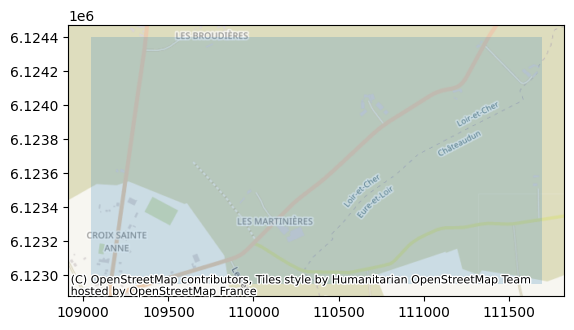

In [84]:
ax = image_loc.to_crs(3857).plot(alpha=0.2)
cx.add_basemap(ax)
df.geom.to_crs(3857).plot(color="red",ax=ax, alpha=1)

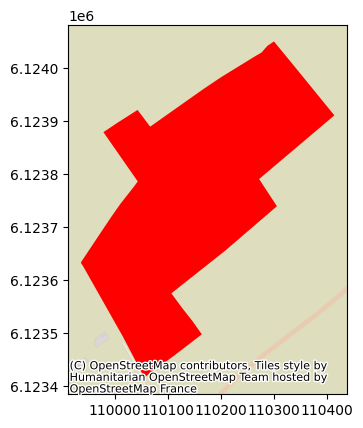

In [12]:
ax = df.head(1).geom.to_crs(3857).plot(color="red", alpha=1)
cx.add_basemap(ax)

# RASTERIO EXPLORATION

In [38]:
import os
import glob
import rasterio
import geopandas as gpd
import numpy as np
import fiona
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt

In [14]:
img = rasterio.open("../data/large_img.jp2")

In [ ]:
mask()

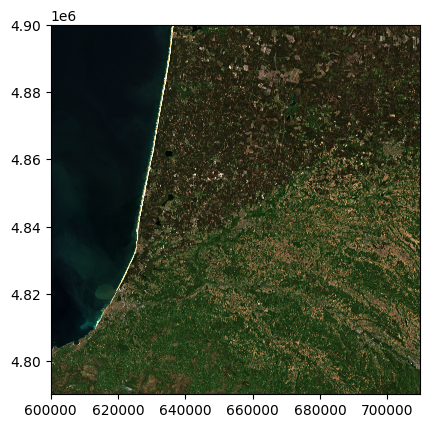

<Axes: >

In [15]:
show(img)

In [24]:
from bs4 import BeautifulSoup

with open("../data/large_img_metadata.xml") as fp:
    soup = BeautifulSoup(fp,'xml')
    coordinates = soup.find('EXT_POS_LIST').text.split()

In [28]:
def bbox(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

In [29]:
coord = [(lat, long) for lat, long in zip(coordinates[::2], coordinates[1::2])]
coord

[('44.24655093494868', '-1.747519127776807'),
 ('44.22320974043625', '-0.37335402628884'),
 ('43.235600960154144', '-0.416191720419125'),
 ('43.25815531909012', '-1.767967299958169'),
 ('44.24655093494868', '-1.747519127776807')]

In [45]:
coordinates

['44.24655093494868',
 '-1.747519127776807',
 '44.22320974043625',
 '-0.37335402628884',
 '43.235600960154144',
 '-0.416191720419125',
 '43.25815531909012',
 '-1.767967299958169',
 '44.24655093494868',
 '-1.747519127776807']

In [46]:
bbox_ = bbox(coord)
bbox_

[('43.235600960154144', '-0.37335402628884'),
 ('44.24655093494868', '-1.767967299958169')]

In [51]:
from satellitecrops.utils.bounding_box import bbox_from_four_points

box = bbox_from_four_points(coordinates)

In [57]:
box[0][0]

'43.235600960154144'

In [108]:
img_coordinates = gpd.read_file("../data/test_location_pays_basque.geojson")
img_coordinates.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

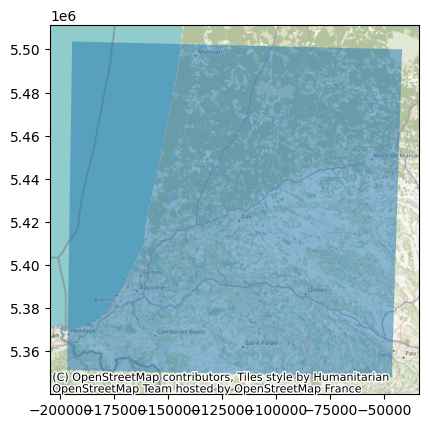

In [112]:
ax = img_coordinates.to_crs(3857).plot(alpha=0.5)
cx.add_basemap(ax)

In [144]:
img_coordinates.to_crs(2154).contains(df.geom).any()

/tmp/ipykernel_121193/1808367553.py:1: UserWarning: The indices of the two GeoSeries are different.
  img_coordinates.to_crs(2154).contains(df.geom).any()


False

In [113]:
df.geom.contains(img_coordinates.to_crs(2154)).any()

/tmp/ipykernel_121193/1387757422.py:1: UserWarning: The indices of the two GeoSeries are different.
  df.geom.contains(img_coordinates.to_crs(2154)).any()


False

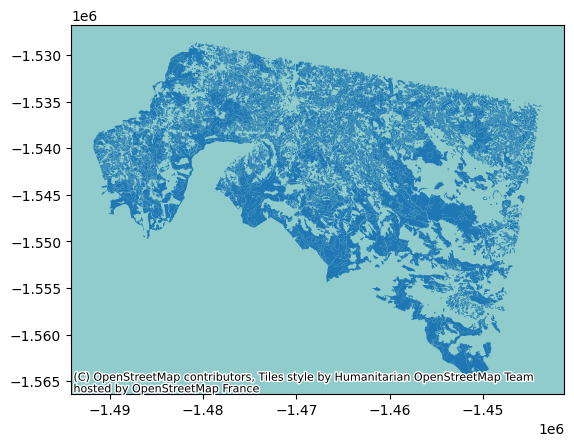

In [119]:
ax = df.geom.to_crs(3854).plot()
cx.add_basemap(ax)

In [129]:
df.geom.head(1).to_crs(3857)

0    POLYGON ((-124030.766 5321731.205, -124073.794...
Name: geom, dtype: geometry

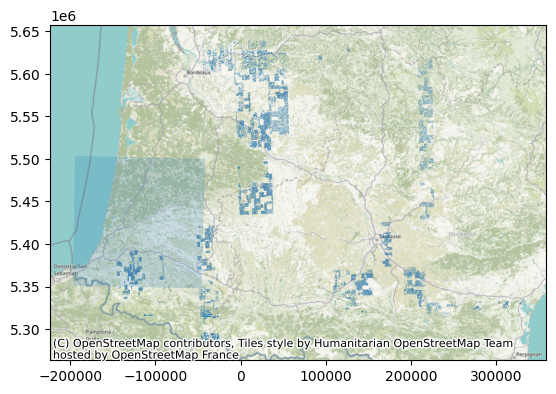

In [142]:
ax = img_coordinates.to_crs(3857).plot(alpha=0.2)
df.geom.to_crs(3857).plot(ax=ax)
cx.add_basemap(ax)

In [160]:
img_coordinates.contains(df.to_crs(4326)).any()

/tmp/ipykernel_121193/2473974944.py:1: UserWarning: The indices of the two GeoSeries are different.
  img_coordinates.contains(df.to_crs(4326)).any()


False

In [156]:
df.geom.to_crs(4326).contains(img_coordinates).any()

/tmp/ipykernel_121193/2566380213.py:1: UserWarning: The indices of the two GeoSeries are different.
  df.geom.to_crs(4326).contains(img_coordinates).any()


False

In [2]:
from satellitecrops.utils.sql_connector import SQLConnection
import geopandas as gpd
import sqlalchemy
conn = SQLConnection()

In [3]:
query = """
SELECT * FROM parcelles_graphiques
WHERE geom && ST_MakeEnvelope(:xmin, :ymin, :xmax, :ymax, :crs)"""

In [117]:
conn.db_conn.execute(sqlalchemy.text(query), {
    "xmin": box[0][0],
    "ymin": box[0][1],
    "xmax": box[1][0],
    "ymax": box[1][1],
    "crs": "4326"}).fetchall()

[]

In [4]:
test_bbox = gpd.read_file("../data/test.geojson")
test_bbox

,geometry
0,"POLYGON ((-1.50463 44.12814, -1.50463 43.53350..."


In [119]:
from geojson.utils import coords
from shapely.geometry import LineString

def get_bbox(geometry):
    print(type(geometry))
    return geometry.bounds


In [130]:
bbox = get_bbox(test_bbox.to_crs(2154).geometry)
bbox

<class 'geopandas.geoseries.GeoSeries'>


,minx,miny,maxx,maxy
0,335940.801826,6.276898e+06,417011.608752,6.346850e+06


In [12]:
parcelles = SQLConnection().get_parcelles_in_bbox(test_bbox.geometry, 2154)
parcelles

[(4883433, '01030000206A08000001000000080000002AC9CA61F55417418E52E1B651F257412BFA634CAB5417416787D0BB57F25741289DF6C619541741BC0D09D260F25741A86BEEDAAE551741B53FEF0C82F257412773BCF451571741B94879E4A3F25741280A4DC4AD571741418AD92D9EF2574128D866953B5817414F1D839097F257412AC9CA61F55417418E52E1B651F25741', '929492', 2.68, 'MIS', '2', '', ''),
 (5610155, '01030000206A0800000100000022000000A32C0681A8FB1841FE4D8BC47E1D58412241B4C83BFB1841846464537E1D58412314022BA8FA1841B24189617E1D5841A5FBFDD4A7F918416A3 ... (824 characters truncated) ... D1841A0BEC8F6AA1D58412112D7A358FE1841A1BEC836921D5841A280E9265EFC1841BAC21E15821D5841A2578D97E8FB1841D1C674837F1D5841A32C0681A8FB1841FE4D8BC47E1D5841', '14744639', 6.53, 'J6P', '11', '', ''),
 (5610156, '01030000206A080000010000001F000000A9305C8F82F218410E7B3D0AA81B5841A8DEA370BBF218411952E15AA51B5841AAAB703DEBF21841E0470A57A31B5841293B333316F31841E61 ... (728 characters truncated) ... 11841585CB80E921B5841AB783D0AD4F11841FCCCF588A71B58412A6E66660CF218410E7

In [6]:
len(parcelles)

62035

In [10]:
gpd.GeoDataFrame(parcelles).geom

0        01030000206A08000001000000080000002AC9CA61F554...
1        01030000206A0800000100000022000000A32C0681A8FB...
2        01030000206A080000010000001F000000A9305C8F82F2...
3        01030000206A0800000100000018000000A7866A7C46E9...
4        01030000206A08000001000000340000003E8AE2C77244...
                               ...                        
62030    01030000206A080000010000000B00000095229E5E7B40...
62031    01030000206A080000010000000C00000094714DF34541...
62032    01030000206A080000010000000500000086D9915C68D4...
62033    01030000206A080000010000000F000000133A55305042...
62034    01030000206A080000010000003D00000094A108DB3F45...
Name: geom, Length: 62035, dtype: object

In [121]:
if test_bbox.crs == 2154:
    print(True)

In [134]:
conn.db_conn.execute(sqlalchemy.text(query),
                     {
                         "xmin": bbox.minx[0],
                         "ymin": bbox.miny[0],
                         "xmax": bbox.maxx[0],
                         "ymax": bbox.maxy[0],
                         "crs": 4326
                     }).fetchall()

[(4883433, '01030000206A08000001000000080000002AC9CA61F55417418E52E1B651F257412BFA634CAB5417416787D0BB57F25741289DF6C619541741BC0D09D260F25741A86BEEDAAE551741B53FEF0C82F257412773BCF451571741B94879E4A3F25741280A4DC4AD571741418AD92D9EF2574128D866953B5817414F1D839097F257412AC9CA61F55417418E52E1B651F25741', '929492', 2.68, 'MIS', '2', '', ''),
 (5610155, '01030000206A0800000100000022000000A32C0681A8FB1841FE4D8BC47E1D58412241B4C83BFB1841846464537E1D58412314022BA8FA1841B24189617E1D5841A5FBFDD4A7F918416A3 ... (824 characters truncated) ... D1841A0BEC8F6AA1D58412112D7A358FE1841A1BEC836921D5841A280E9265EFC1841BAC21E15821D5841A2578D97E8FB1841D1C674837F1D5841A32C0681A8FB1841FE4D8BC47E1D5841', '14744639', 6.53, 'J6P', '11', '', ''),
 (5610156, '01030000206A080000010000001F000000A9305C8F82F218410E7B3D0AA81B5841A8DEA370BBF218411952E15AA51B5841AAAB703DEBF21841E0470A57A31B5841293B333316F31841E61 ... (728 characters truncated) ... 11841585CB80E921B5841AB783D0AD4F11841FCCCF588A71B58412A6E66660CF218410E7

In [83]:
res = SQLConnection().select("""
                       SELECT code_cultu, COUNT(*) FROM parcelles_graphiques GROUP BY code_cultu""")

In [85]:
len(res)

239

In [86]:
res

[('AGR', 932),
 ('AIL', 2220),
 ('ANE', 61),
 ('ANG', 53),
 ('ANI', 6),
 ('ARA', 13),
 ('ART', 3564),
 ('AUB', 280),
 ('AVH', 14753),
 ('AVO', 23),
 ('AVP', 23692),
 ('BAR', 15),
 ('BAS', 114),
 ('BDH', 41885),
 ('BDP', 5190),
 ('BFP', 14610),
 ('BFS', 24724),
 ('BLT', 78),
 ('BOP', 84377),
 ('BOR', 108018),
 ('BRH', 32),
 ('BRO', 164),
 ('BTA', 317492),
 ('BTH', 803705),
 ('BTN', 58647),
 ('BTP', 11390),
 ('BVF', 8603),
 ('CAB', 13),
 ('CAE', 2804),
 ('CAF', 17),
 ('CAG', 1373),
 ('CAR', 3611),
 ('CAV', 9),
 ('CBT', 919),
 ('CCN', 302),
 ('CCT', 1607),
 ('CEE', 4256),
 ('CEL', 750),
 ('CES', 2692),
 ('CGF', 13),
 ('CGH', 23),
 ('CGO', 241),
 ('CGP', 219),
 ('CHA', 92),
 ('CHF', 486),
 ('CHH', 60),
 ('CHR', 92),
 ('CHS', 27),
 ('CHT', 901),
 ('CHU', 12122),
 ('CHV', 3356),
 ('CIB', 77),
 ('CID', 433),
 ('CIT', 100),
 ('CMB', 2280),
 ('CML', 354),
 ('CMM', 167),
 ('CPA', 119),
 ('CPH', 48),
 ('CPL', 4546),
 ('CPS', 3),
 ('CPT', 89),
 ('CPZ', 8),
 ('CRD', 771),
 ('CRF', 37),
 ('CRS', 45)

In [20]:
from satellitecrops.utils.sql_connector import SQLConnection
from satellitecrops.eolearn.pipeline import get_zone_to_patch, get_parcelles_from_db
from satellitecrops.utils.bucket import BucketConnector

In [11]:
sql = SQLConnection()
bucket = BucketConnector()

In [12]:
zone = get_zone_to_patch(bucket)


⏳ Loading department zone
✅ Departement zone loaded


In [23]:
import os

In [24]:
parcelles_path = os.path.join("../data/departments/landes/", f"landes_parcelles.geojson")

In [25]:
os.path.isfile(parcelles_path)

True

In [38]:
import geopandas as gpd
import pandas as pd

In [33]:
parcelles_df = gpd.read_file(parcelles_path)

In [92]:
parcelles_df["id_group"] = [0] * len(parcelles_df)

In [39]:
df = pd.read_csv("../data/mapping_crops.csv")
df.head()

,CODE CULTURE,LIBELLÉ,cat_crops,id
0,BTH,Blé tendre d’hiver,Blé,1
1,BTP,Blé tendre de printemps,Blé,1
2,MID,Maïs doux,Maïs,6
3,MIE,Maïs ensilage,Maïs,6
4,MIS,Maïs,Maïs,6


In [84]:
df[df["CODE CULTURE"] == "BTH"].id[0]

1

In [102]:
for code in df["CODE CULTURE"]:
    # print(df[df["CODE CULTURE"] == code]["id"].iloc[0])
    parcelles_df.loc[parcelles_df["code_cultu"] == code, 'id_group'] = df[df["CODE CULTURE"] == code].id.iloc[0]

In [104]:
parcelles_df.id_group.value_counts()

id_group
 10.0    85114
 6.0     39580
 13.0     8415
 12.0     4339
 7.0      3566
 5.0      2044
 4.0      1886
 11.0     1694
 1.0      1691
 3.0      1444
 8.0       510
 9.0       116
 0.0        37
-1.0        15
 2.0         4
Name: count, dtype: int64